# DWD Weather Station Data
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/

In [ ]:
import os
import re
import sys
import yaml
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from shapely.geometry import Point
from collections import defaultdict

<b>Weather Stations in Germany for:</b></br></br>
relative humidity (%)</br>
air pressure at station level (hPa)</br>
air temperature near ground (°C)</br>
air temperature at 2 m (°C)</br>
dew point temperature (°C)</br>

diffuse radiation (J/cm<sup>2</sup>)</br>
global radiation (J/cm<sup>2</sup>)</br>
sunshine duration (hours)</br>

wind direction (degree)</br>
wind velocity (m/s)

In [5]:
def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

In [6]:
config_path = "config.yaml"
config = load_config(config_path)

directory = config['data']['dir']
target_dir = config['data']['final_data']
params = config['synth']

vars = config['scraping']['vars']
solar_dir = config['data']['solar_dir']
wind_dir = config['data']['wind_dir']
threshold = params['threshold'] # tolerance threshold for acepting share of missing values

In [7]:
to_date = '2023-12-31'#config['data']['to_date']
from_date = '2023-07-24'#config['data']['from_date']
validate_on_quality = False
column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]
features = []
for feature in params:
    if not feature == 'threshold':
        features.append(params[feature]['param'])
# get all station files
station_files = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    if not any(var in root for var in vars):
            continue
    for file in files:
        if 'Stationen' in file:
            station_files.append(os.path.join(root, file))
# read all station files
stations = None
for station in station_files:
    df_station = pd.read_fwf(station, 
                             encoding='latin1',
                             skiprows=2,
                             names=column_names)
    df_station['von_datum'] = pd.to_datetime(df_station['von_datum'], format='%Y%m%d')
    df_station['bis_datum'] = pd.to_datetime(df_station['bis_datum'], format='%Y%m%d')
    df_station.drop(['Abgabe'], axis=1, inplace=True)
    table_name = station.split('/')[-2]
    df_station['Table'] = table_name
    if station != None:
        stations = pd.concat([stations, df_station], ignore_index=True)
    else:
        stations = df_station.copy()
stations['Stations_id'] = stations["Stations_id"].apply(lambda x: f"{x:05d}")

In [8]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Stations_id    1119 non-null   object        
 1   von_datum      1119 non-null   datetime64[ns]
 2   bis_datum      1119 non-null   datetime64[ns]
 3   Stationshoehe  1119 non-null   int64         
 4   geoBreite      1119 non-null   float64       
 5   geoLaenge      1119 non-null   float64       
 6   Stationsname   1119 non-null   object        
 7   Bundesland     1119 non-null   object        
 8   Table          1119 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 78.8+ KB


In [9]:
stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Table
0,00003,1993-04-29,2011-03-31,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen,air_temperature
1,00044,2007-02-09,2025-03-25,44,52.9336,8.2370,Großenkneten,Niedersachsen,air_temperature
2,00071,2009-12-01,2019-12-31,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg,air_temperature
3,00073,2007-02-15,2025-03-25,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern,air_temperature
4,00078,2004-10-12,2025-03-25,64,52.4853,7.9125,Alfhausen,Niedersachsen,air_temperature
...,...,...,...,...,...,...,...,...,...
1114,15978,2020-04-02,2025-03-25,316,49.5044,7.8618,Sembach,Rheinland-Pfalz,wind_test
1115,19171,2020-09-01,2025-03-25,13,54.0039,9.8555,Hasenkrug-Hardebek,Schleswig-Holstein,wind_test
1116,19207,2023-04-01,2025-03-25,16,53.8178,12.0645,Gülzow-Prüzen,Mecklenburg-Vorpommern,wind_test
1117,19243,2024-01-01,2025-03-25,8,54.6831,8.4721,Föhr,Schleswig-Holstein,wind_test


In [10]:
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    if not any(var in root for var in vars):
        continue
    print(f'In {root} are {len(files)} files.')

print('')
print('')
print(stations.groupby('Table').size().sort_index(ascending=False))

print('\n It is likely that data is not available for all stations.')

In /mnt/nasl1/observed_weather/air_temperature are 2090 files.
In /mnt/nasl1/observed_weather/solar are 1262 files.
In /mnt/nasl1/observed_weather/wind_test are 1036 files.


Table
wind_test          274
solar              325
air_temperature    520
dtype: int64

 It is likely that data is not available for all stations.


In [11]:
stations.drop(stations[stations.bis_datum < to_date].index, inplace=True)
stations.drop(stations[stations.von_datum > from_date].index, inplace=True)

counts = stations.groupby(['Stations_id']).size().value_counts().sort_index()
table_counts = stations.groupby(['Stations_id', 'Table']).size()

print(f'{len(stations.Stations_id.unique())} unique weather stations \n')

for e, c in enumerate(counts, start=1):
    print(f'{c} stations with values in {e} tables.')

print('\nAbsolute number of stations for:')
stations.groupby('Table').size()

534 unique weather stations 

286 stations with values in 1 tables.
99 stations with values in 2 tables.
149 stations with values in 3 tables.

Absolute number of stations for:


Table
air_temperature    469
solar              193
wind_test          269
dtype: int64

In [12]:
stations

,Stations_id,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland,Table
1,00044,2007-02-09,2025-03-25,44,52.9336,8.2370,Großenkneten,Niedersachsen,air_temperature
3,00073,2007-02-15,2025-03-25,374,48.6183,13.0620,Aldersbach-Kramersepp,Bayern,air_temperature
4,00078,2004-10-12,2025-03-25,64,52.4853,7.9125,Alfhausen,Niedersachsen,air_temperature
5,00091,2002-08-21,2025-03-25,304,50.7446,9.3450,Alsfeld-Eifa,Hessen,air_temperature
6,00096,2019-04-10,2025-03-25,50,52.9437,12.8518,Neuruppin-Alt Ruppin,Brandenburg,air_temperature
...,...,...,...,...,...,...,...,...,...
1112,15911,2021-06-01,2025-03-25,279,51.1347,14.4344,Großpostwitz-Denkwitz,Sachsen,wind_test
1113,15976,2020-04-02,2025-03-25,216,49.9529,8.2107,Ober-Olm/Bellem,Rheinland-Pfalz,wind_test
1114,15978,2020-04-02,2025-03-25,316,49.5044,7.8618,Sembach,Rheinland-Pfalz,wind_test
1115,19171,2020-09-01,2025-03-25,13,54.0039,9.8555,Hasenkrug-Hardebek,Schleswig-Holstein,wind_test


In [13]:
grouped = stations.groupby(['Stations_id'])['Table'].apply(list)

combination_counts = {}
for categories in grouped:
    for pair in combinations(categories, 2):
        pair = tuple(sorted(pair))
        combination_counts[pair] = combination_counts.get(pair, 0) + 1
    
grouped_counts = stations.groupby(["Stations_id", "Table"]).size().unstack(fill_value=0)
single_entries = grouped_counts[grouped_counts.sum(axis=1) == 1].sum()

matrix = pd.DataFrame(0, index=vars, columns=vars)

for (cat1, cat2), count in combination_counts.items():
    matrix.loc[cat1, cat2] += count
    matrix.loc[cat2, cat1] += count  

for category in vars:
    if category in single_entries:
        matrix.loc[category, category] = single_entries[category]
        
print(matrix)
temp_temp = str(matrix['air_temperature'].loc['air_temperature'])
temp_solar = str(matrix['air_temperature'].loc['solar'])
print('')
print(f'There are {temp_temp} stations where air_temperature was the only measurement.')
print(f'There are {temp_solar} stations where air_temperature and solar are measured.')

                 air_temperature  solar  wind_test
air_temperature              221    193        204
solar                        193      0        149
wind_test                    204    149         65

There are 221 stations where air_temperature was the only measurement.
There are 193 stations where air_temperature and solar are measured.


In [14]:
valid_stations = (
    stations.groupby("Stations_id")["Table"]
    .apply(lambda x: set(x) == set(vars))
)

valid_stations_ids = valid_stations[valid_stations].index

stations3 = stations[stations["Stations_id"].isin(valid_stations_ids)]

149 unique weather stations after cleaning. 



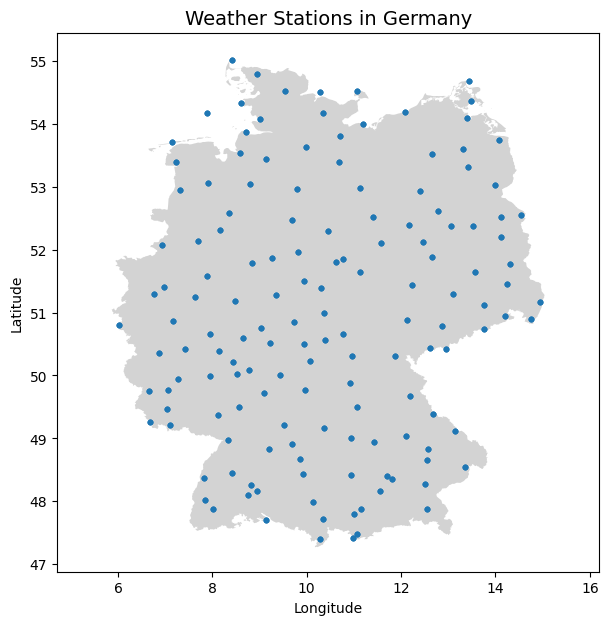

In [15]:
germany = gpd.read_file('geoBoundaries-DE.geojson')

geometry = [Point(xy) for xy in zip(stations3['geoLaenge'], stations3['geoBreite'])]
geo_df = gpd.GeoDataFrame(stations3, geometry=geometry)

print(f'{len(stations3.Stations_id.unique())} unique weather stations after cleaning. \n')

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Weather Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [16]:
stations_ids = stations3.Stations_id.unique()

# get list of relevant station files
file_paths = []
for root, dirs, files in os.walk(directory):
    if ('data/Archiv' in root) | ('data/final' in root):
        continue
    if not any(var in root for var in vars):
            continue
    for file in files:
        if 'produkt' in file:
            file_split = re.split(r'[_\.]', file)
            
            to_date_file = datetime.strptime(file_split[5], '%Y%m%d')
            
            in_date = not to_date_file < datetime.strptime(to_date, '%Y-%m-%d')  
            in_ids = file_split[-2] in stations_ids
            
            if in_date and in_ids:
                file_paths.append(os.path.join(root, file))

In [17]:
# check if the list of files contains all relevant stations
extracted_data = []

for path in file_paths:
    parts = re.split(r'[\/_.]', path) 
    category = parts[-9]
                   
    if category == "temperature":
        category = "air_temperature"
        date = parts[8]       
        station_id = parts[9]
    elif category == 'test':
        category = 'wind_test'
        date = parts[8]       
        station_id = parts[9] 
    else:
        date = parts[7]       
        station_id = parts[8]
           
    extracted_data.append([category, date, station_id])

df_proof = pd.DataFrame(extracted_data, columns=["Category", "Date", "Stations_ID"])


In [18]:
df_proof.groupby('Category').size()

Category
air_temperature    298
solar              298
wind_test          298
dtype: int64

In [19]:
proof = [id for id in df_proof.Stations_ID.unique() if not id in stations_ids]
        
if proof:
    print('There are inconsistent stations in your dataframe.')
else:
    print('The stations are consistent with your stations_ids list.')

There are inconsistent stations in your dataframe.


In [20]:
# group paths by stations_id

grouped = defaultdict(lambda: {var: None for var in vars})

for path in file_paths:
    parts = re.split(r'[\/_.]', path)
    category = parts[-9]  
    station_id = parts[-2]
    
    if category == 'temperature':
        category = 'air_temperature'
    if category == 'test':
        category = 'wind_test'
    
    grouped[station_id][category] = path

structured_list = []
for station_id, paths in grouped.items():
    if all(paths[cat] for cat in vars):
        structured_list.append([paths[var] for var in vars])

In [21]:
# merge dataframes by stations_ids

final_df = []
val_results = []

def make_final_frames(validate_on_quality=False):
    for ele in structured_list:
        station_df = None
        
        for file in ele:
            station_id = re.search(r'_(\d{5})\.txt$', file).group(1)
            raw = pd.read_csv(file, sep=';')
            raw['timestamp'] = pd.to_datetime(raw['MESS_DATUM'], format='%Y%m%d%H%M')
            raw.set_index('timestamp', inplace=True)
            
            if validate_on_quality:
                category = structured_list[0][0].split('/')[1]
                q1 = raw['  QN'].quantile(0.25)
                q2 = raw['  QN'].quantile(0.5)
                q3 = raw['  QN'].quantile(0.75)
                val_results.append([station_id, category, q1, q2, q3])
            raw.drop(['MESS_DATUM', '  QN', 'eor'], axis=1, inplace=True)
            raw['STATIONS_ID'] = station_id
            
            if station_df is not None:
                station_df = pd.merge(station_df, raw, how='inner', on=['timestamp', 'STATIONS_ID'])
            else:
                station_df = raw.copy()
        station_id = station_df.STATIONS_ID.iloc[0]
        cols = ['Stationshoehe', 'geoBreite', 'geoLaenge']
        col_vals = stations3[stations3.Stations_id == station_id][cols].drop_duplicates().values
        col_vals = np.tile(col_vals, (len(station_df), 1))
        station_df[cols[0]] = col_vals[:,0]
        station_df[cols[1]] = col_vals[:,1]
        station_df[cols[2]] = col_vals[:,2]
        
        final_df.append(station_df[from_date:])
    
    if validate_on_quality:
        val_df = pd.DataFrame(data=val_results, columns=['Station_ID', 'Category', 'Q1', 'Q2', 'Q3'])
        return final_df, val_df
    return final_df

In [22]:
result = make_final_frames(validate_on_quality=validate_on_quality)

if validate_on_quality:
    final_df = result[0]
    val_df = result[1]
else:
    final_df = result

Check Quality Niveau of Measurements

In [19]:
low_qn_stations = []

if validate_on_quality:
    low_qn_stations.append(val_df.loc[val_df['Q1'] != 3.0])
    low_qn_stations.append(val_df.loc[val_df['Q2'] != 3.0])
    low_qn_stations.append(val_df.loc[val_df['Q3'] != 3.0])
    
    for i, station in enumerate(low_qn_stations):
        print(f'Stations with Quality != 3 at Q{i+1}:')
        print(station['Station_ID'].unique())

Check missing values

In [20]:
missings = {}

for df in final_df:
    station_id = df.STATIONS_ID.iloc[0]
    mask = (df == -999.0) | (df == -9999.0)
    column_counts = mask.sum()
    missings[station_id] = column_counts.values

df_missing = pd.DataFrame.from_dict(missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

for col in df_missing.columns:
    if col not in features:
        df_missing.drop(col, axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [21]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,SLA_10,SLO_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,3684.450000,371.633333,435.758333,462.058333,610.583333,610.583333,511.200000,511.033333,17857.833333,17675.883333,1034.008333
std,15806.018646,623.671522,811.267781,909.308781,784.023244,784.023244,723.865552,723.576608,31860.700282,31946.478138,7198.965804
min,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,0.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,8.500000,8.500000,12.250000,72.500000,72.500000,35.750000,35.750000,132.750000,85.750000,9.750000
50%,52.000000,87.500000,107.000000,107.000000,329.000000,329.000000,268.500000,268.500000,810.000000,577.500000,132.000000
75%,482.500000,454.250000,568.500000,569.250000,847.500000,847.500000,635.250000,635.250000,7180.500000,6101.500000,444.750000
max,78912.000000,3279.000000,6546.000000,7629.000000,4481.000000,4481.000000,4003.000000,4003.000000,78912.000000,78912.000000,78912.000000


In all 132 stations and several columns there are missing values.

The features DS_10 (Diffuse Horizontal Irradiance) and GS_10 (Global Horizontal Irradiance) has the most missing values.

Air Pressure (PP_10) also has high missing values, but here we can impute by pvlibs pressure to altitude method.

Dataframes with the highest number of missing values are dropped.

In [22]:
analysis = {}

for df in final_df:
    ghi = df[params['ghi']['param']]
    dhi = df[params['dhi']['param']]  
    missing_ghi = ghi.isin([-9999.0, -999.0]).sum() / len(ghi) * 100
    missing_dhi = dhi.isin([-9999.0, -999.0]).sum() / len(dhi) * 100   
    missing_percentage = missing_ghi, missing_dhi  
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing_percentage

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["GHI %", 'DHI %'])

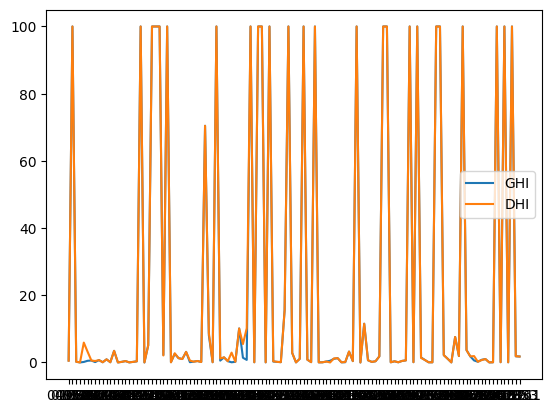

In [23]:
plt.plot(analysis_df['GHI %'], label='GHI')
plt.plot(analysis_df['DHI %'], label='DHI')

plt.legend()

In [24]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['GHI %'] > threshold*100) | (analysis_df['DHI %'] > threshold*100)]

len(stations_more_x_perc_missing)

solar_drop_stations = stations_more_x_perc_missing.index

The same for precipiation

In [25]:
analysis = {}

for df in final_df:
    prec = df[params['prec']['param']]
    missing = prec.isin([-9999.0, -999.0]).sum() / len(prec) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

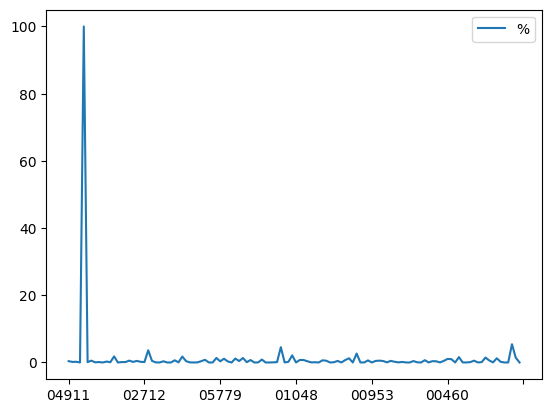

In [26]:
analysis_df.plot()

In [27]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > 10)]
len(stations_more_x_perc_missing)
solar_drop_stations = solar_drop_stations.append(stations_more_x_perc_missing.index)

The same for pressure

In [28]:
analysis = {}

for df in final_df:
    pressure = df[params['pressure']['param']]
    missing = pressure.isin([-9999.0, -999.0]).sum() / len(pressure) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

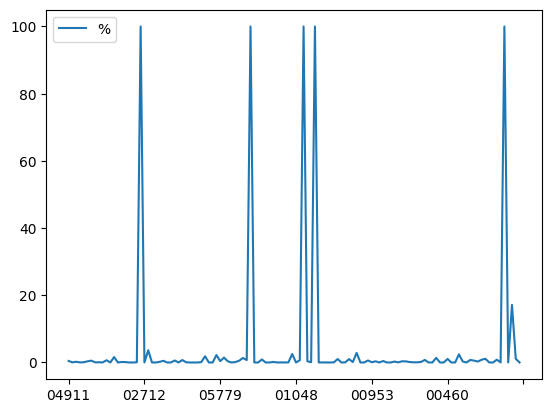

In [29]:
analysis_df.plot()#sort_values(by='%', ascending=False)

In [30]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > 20)]

len(stations_more_x_perc_missing)

wind_drop_stations = stations_more_x_perc_missing.index

The same for wind speed

In [31]:
analysis = {}

for df in final_df:
    wind_speed = df[params['v_wind']['param']]
    missing = wind_speed.isin([-9999.0, -999.0]).sum() / len(wind_speed) * 100
    station_id = df['STATIONS_ID'].iloc[0]
    analysis[station_id] = missing

analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=["%"])

<Axes: >

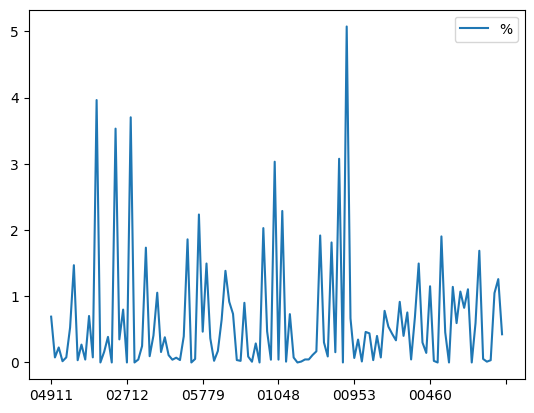

In [32]:
analysis_df.plot()#sort_values(by='%', ascending=False)

In [33]:
stations_more_x_perc_missing = analysis_df.loc[(analysis_df['%'] > threshold*100)]
len(stations_more_x_perc_missing)
wind_drop_stations = wind_drop_stations.append(stations_more_x_perc_missing.index)

In [34]:
wind_df = []
solar_df = []

dew = params['dewpoint']['param']
ghi = params['ghi']['param']
dhi = params['dhi']['param']
prec = params['prec']['param']
solar_features = [dew, ghi, dhi, prec]
sla = params['sigma_wind_lat']['param']
slo = params['sigma_wind_lon']['param']
wind_features = [sla, slo]

also_drop = ['RWS_DAU_10', 'RWS_IND_10', 'TM5_10', 'LS_10', 'SD_10']
solar_features.extend(also_drop)
wind_features.extend(also_drop)

for df in final_df:
    station_id = df['STATIONS_ID'].iloc[0]
    if not station_id in set(wind_drop_stations):
        wind_df.append(df.drop(solar_features, axis=1))
    if not station_id in set(solar_drop_stations):
        solar_df.append(df.drop(wind_features, axis=1))

In [35]:
len(solar_df), len(wind_df)

(59, 89)

Now it should be analyzed in the solar dataframes which hours has the most missing values, because the night hours can directly be imputed with zeros.

In [36]:
rad_analysis = {}

for df in solar_df:
    ghi = df[params['ghi']['param']]
    dhi = df[params['dhi']['param']]
    missing_mask = (ghi.isin([-9999.0, -999.0]) |
                    dhi.isin([-9999.0, -999.0]))
    df['hour'] = df.index.hour
    missing_hours = df.loc[missing_mask, 'hour']
    hourly_counts = missing_hours.value_counts().sort_index()
    station_id = df['STATIONS_ID'].iloc[0]
    rad_analysis[station_id] = hourly_counts
    df.drop('hour', axis=1, inplace=True)

rad_analysis_df = pd.DataFrame.from_dict(rad_analysis, orient='index').fillna(0)

In [37]:
rad_analysis_df.median().sort_index()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
5      0.0
6      3.0
7      6.0
8      9.0
9     12.0
10    17.0
11    12.0
12     6.0
13     6.0
14     6.0
15     6.0
16     0.0
17     0.0
18     0.0
19     0.0
20     0.0
21     0.0
22     0.0
23     0.0
dtype: float64

The nighttime hours are less missing, indicating that sequences of missing values could be possible.

The following is an analysis of how often it occurs, that more than 1 hour in a row is missing.

In [38]:
missings = {}
missing_hours = 6 * 1

for df in solar_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        sequence_lengths = mask.groupby((~mask).cumsum()).transform('sum')
        long_sequences_count = (sequence_lengths > missing_hours).astype(int).diff().fillna(0).eq(1).sum()
        column_counts[column] = long_sequences_count

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(data=missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [39]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,1.101695,1.661017,1.898305,1.915254,3.372881,3.372881,3.610169,3.457627,2.949153
std,1.360716,1.944135,2.249099,2.238289,3.247802,3.247802,3.156913,2.731187,3.941047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.500000
50%,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,1.000000
75%,2.000000,2.000000,3.000000,3.000000,4.000000,4.000000,5.000000,4.500000,3.000000
max,7.000000,10.000000,12.000000,12.000000,15.000000,15.000000,15.000000,15.000000,16.000000


The same for the wind frames:

In [40]:
missings = {}
missing_hours = 6 * 1

for df in wind_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        sequence_lengths = mask.groupby((~mask).cumsum()).transform('sum')
        long_sequences_count = (sequence_lengths > missing_hours).astype(int).diff().fillna(0).eq(1).sum()
        column_counts[column] = long_sequences_count

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(data=missings, orient='index', columns=df.columns)
df_missing.drop(['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge'], axis=1, inplace=True)

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [41]:
df_missing.describe()

,PP_10,TT_10,RF_10,SLA_10,SLO_10,FF_10,DD_10
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,1.095238,1.880952,2.142857,5.202381,5.202381,3.261905,3.261905
std,1.358765,2.008445,2.360023,8.037232,8.037232,2.680222,2.680222
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.750000,2.000000,2.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000
75%,2.000000,3.000000,3.000000,5.000000,5.000000,4.000000,4.000000
max,7.000000,10.000000,12.000000,67.000000,67.000000,13.000000,13.000000


The following is an analysis of how long are the missing sequences in average per station.

In [42]:
missings = {}

for df in solar_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        group_sizes = mask.groupby((~mask).cumsum()).sum()  # Gruppengrößen berechnen
        mean_length = group_sizes[group_sizes > 0].mean()  # Mittlere Länge der Sequenzen berechnen
        column_counts[column] = mean_length if not pd.isna(mean_length) else 0  # NaN durch 0 ersetzen

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(missings, orient='index')

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [43]:
df_missing.describe()

,PP_10,TT_10,RF_10,TD_10,FF_10,DD_10,DS_10,GS_10,RWS_10
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,58.108111,55.439548,54.502152,53.211192,77.264066,77.264066,39.033948,37.502189,63.163690
std,108.368411,97.409665,100.196548,95.410592,116.813196,116.813196,84.433012,80.530755,107.136269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,0.000000,0.000000,1.750000,14.000000,14.000000,8.000000,8.000000,5.250000
50%,13.000000,20.666667,20.000000,20.333333,34.000000,34.000000,15.222222,14.200000,24.000000
75%,51.875000,52.250000,45.380952,45.380952,87.761905,87.761905,37.466667,39.125000,53.250000
max,595.000000,599.000000,599.000000,599.000000,596.000000,596.000000,596.000000,596.000000,540.000000


The same for wind:

In [44]:
missings = {}

for df in wind_df:
    column_counts = {}
    station_id = df.STATIONS_ID.iloc[0]
    for column in df.columns:
        if column in ['STATIONS_ID', 'Stationshoehe', 'geoBreite', 'geoLaenge']:
            continue
        
        mask = (df[column] == -999.0) | (df[column] == -9999.0)
        group_sizes = mask.groupby((~mask).cumsum()).sum()  # Gruppengrößen berechnen
        mean_length = group_sizes[group_sizes > 0].mean()  # Mittlere Länge der Sequenzen berechnen
        column_counts[column] = mean_length if not pd.isna(mean_length) else 0  # NaN durch 0 ersetzen

    missings[station_id] = column_counts

df_missing = pd.DataFrame.from_dict(missings, orient='index')

df_missing = df_missing.loc[:, (df_missing != 0).any(axis=0)]
df_missing = df_missing.loc[(df_missing != 0).any(axis=1)]

In [45]:
df_missing.describe()

,PP_10,TT_10,RF_10,SLA_10,SLO_10,FF_10,DD_10
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,65.028036,72.482691,83.360077,18.821657,18.821657,70.166860,70.166860
std,119.968255,124.015464,143.237489,22.843303,22.843303,115.576754,115.576754
min,0.000000,0.000000,0.000000,1.058065,1.058065,0.000000,0.000000
25%,0.000000,0.000000,0.000000,4.461538,4.461538,14.500000,14.500000
50%,15.000000,23.500000,23.000000,7.585366,7.585366,35.583333,35.583333
75%,67.000000,79.500000,106.000000,27.500000,27.500000,75.000000,75.000000
max,705.000000,705.000000,711.000000,121.500000,121.500000,711.000000,711.000000


In [46]:
for pv in solar_df:
    pv.replace({-999.0: np.nan, -9999.0: np.nan}, inplace=True)
    
for w in wind_df:
    w.replace({-999.0: np.nan, -9999.0: np.nan}, inplace=True)

In [47]:
pv_stations_list = []
wind_stations_list = []

for pv, w in zip(solar_df, wind_df):
    
    lon = params['longitude']['param']
    lat = params['latitude']['param']
    
    pv_stations_list.append([pv['STATIONS_ID'].values[0], pv[lon].values[0], pv[lat].values[0]])
    wind_stations_list.append([w['STATIONS_ID'].values[0], w[lon].values[0], w[lat].values[0]])
    
pv_stations = pd.DataFrame(data=pv_stations_list, columns=['Station_id', 'Lon', 'Lat'])
wind_stations = pd.DataFrame(data=wind_stations_list, columns=['Station_id', 'Lon', 'Lat'])

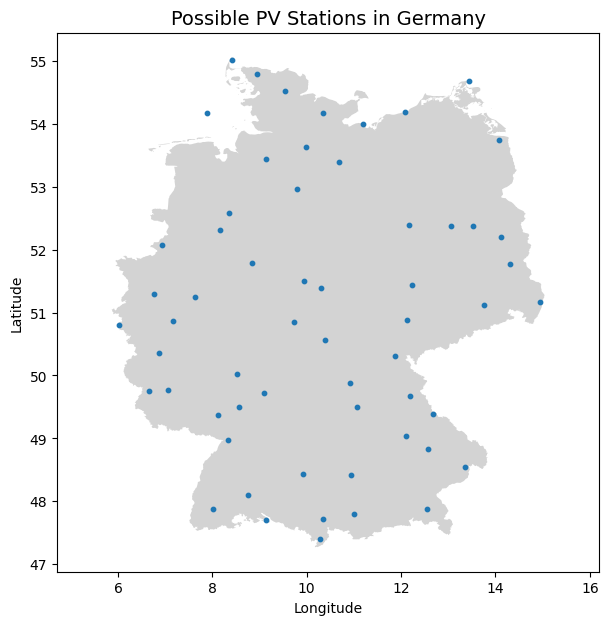

In [48]:
geometry = [Point(xy) for xy in zip(pv_stations['Lon'], pv_stations['Lat'])]
geo_df = gpd.GeoDataFrame(pv_stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Possible PV Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

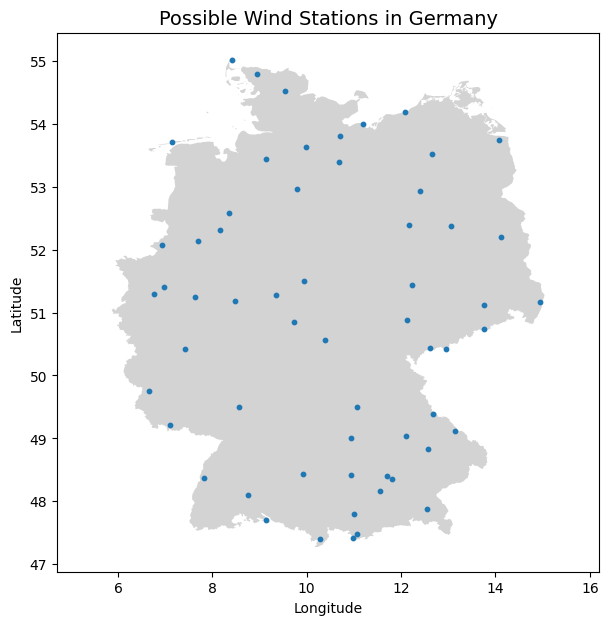

In [49]:
geometry = [Point(xy) for xy in zip(wind_stations['Lon'], wind_stations['Lat'])]
geo_df = gpd.GeoDataFrame(wind_stations, geometry=geometry)

fig, ax = plt.subplots(figsize=(7, 7))
germany.plot(ax=ax, color='lightgrey')  
geo_df.plot(ax=ax, 
            label='Stations', 
            markersize=10, 
            legend=True)

stretch_factor = 0.75 
ax.set_aspect(1 / stretch_factor, adjustable='datalim')

plt.title('Possible Wind Stations in Germany', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [50]:
print(f'{len(solar_df)} solar stations.')
print(f'{len(wind_df)} wind stations.')

59 solar stations.
89 wind stations.


In [51]:
# write csv from final dataframes

os.makedirs(target_dir, exist_ok=True)
os.makedirs(solar_dir, exist_ok=True)
os.makedirs(wind_dir, exist_ok=True)
for df in solar_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(solar_dir, file_name)
    df.to_csv(dir)
    
for df in wind_df:
    file_name = f'Station_{str(df.STATIONS_ID.unique()[0])}.csv'
    dir = os.path.join(wind_dir, file_name)
    df.to_csv(dir)